In [13]:
from alab_experiment_helper import Experiment, sample, tasks
from alab_experiment_helper.sample import Sample

ImportError: cannot import name 'Experiment' from 'alab_experiment_helper' (/Users/REKumar/GitHub/alab_experiment_helper/alab_experiment_helper/__init__.py)

In [ ]:
import networkx as nx

In [ ]:
from bson import ObjectId
import numpy as np

def generate_sample(exp):
    s = exp.add_sample(name=ObjectId())
    powders_a = ["MAI", "FAI"]
    powders_b = ["PbI2", "PbBr2", "PbCl2"]

    powder_dispenses = {
        np.random.choice(powders_a): np.random.random()*10,
        np.random.choice(powders_b): np.random.random()*10,
    }
    tasks.dispensing(
        s,
        powder_dispenses=powder_dispenses,
    )
    tasks.simple_heating_with_atmosphere(
        s,
        heating_temperature_celsius=np.random.choice([800,1200]),
        heating_time_minutes = np.random.choice([480, 1200]),
        atmosphere = np.random.choice(["N2", "Ar"]),
    )
    tasks.recover_powder(s)
    tasks.xrd(s)
    return s


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from networkx.drawing.nx_agraph import graphviz_layout
def plot_task_graph(graph, pos_function = None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    color_key = {}
    node_colors = []
    for node_id, node in graph.nodes(data=True):
        if node["type"] not in color_key:
            color_key[node["type"]] = plt.cm.tab10(len(color_key))
        node_colors.append(color_key[node["type"]])

    if pos_function is None:
        try:
            pos = graphviz_layout(graph, prog="dot")
        except:
            pos = nx.spring_layout(graph)
    else:
        pos = pos_function(graph)
    nx.draw(
        graph, 
        pos=pos,
        with_labels=False, 
        labels={n: nd["type"] for n, nd in graph.nodes(data=True)},
        node_color = node_colors,
        node_size=50,
        ax=ax
        )

    legend_elements = [
        Line2D([0], [0], marker="o", color=c, label=l, linestyle="")
        for l,c in color_key.items()
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor = (1.05, 1), loc = "upper left")

In [ ]:
def count_nodes(graph):
    node_counts = {}    
    for node_id, node in graph.nodes(data=True):
        if node["type"] not in node_counts:
            node_counts[node["type"]] = 0
        node_counts[node["type"]] += 1
    return node_counts

-----
# Batch nodes all at once

In [ ]:
from typing import Callable
def merge_nodes(graph:nx.DiGraph, node_type:str, parent_graph:nx.DiGraph = None, merge_allowed_fn:Callable = None) -> nx.DiGraph:
    if parent_graph is None:
        parent_graph = graph
    node_ids = list(graph.nodes)
    removed_nodes = []
    for reference_node_id in node_ids:
        if reference_node_id in removed_nodes:
            continue
        # reference_node_id = node_ids[reference_index]
        try:
            ref = graph.nodes[reference_node_id]
        except:
            break #we merged nodes, so ran out of entries early. This is fine, just end the loop.
        replace = []
        capacity = ref["capacity"]
        ref_samples = ref["samples"]
        ref_params_per_sample = ref["parameters_per_sample"]

        for tid, task in graph.nodes(data=True):
            if tid == reference_node_id:
                continue
            if task["type"] != ref["type"]:
                continue
            if task["type"] != node_type:
                continue
            if len(task["samples"]) + len(ref_samples) > capacity:
                continue
            if merge_allowed_fn is not None:
                if not merge_allowed_fn(ref, task):
                    continue

            replace.append(tid)
            ref_samples.extend(task["samples"])
            ref_params_per_sample.update(task["parameters_per_sample"])

            if len(ref_samples) == capacity:
                break
        
        if len(replace) == 0:
            continue
        for replace_id in replace:
            for prev in parent_graph.predecessors(replace_id):
                parent_graph.add_edge(prev, reference_node_id)
            for next in parent_graph.successors(replace_id):
                parent_graph.add_edge(reference_node_id, next)
            parent_graph.remove_node(replace_id)
            removed_nodes.append(replace_id)
        parent_graph.nodes[reference_node_id]["samples"] = ref_samples
        parent_graph.nodes[reference_node_id]["parameters_per_sample"] = ref_params_per_sample
    return graph


In [ ]:
exp = Experiment("dummy")
for i in range(10):
    generate_sample(exp)
exp.to_dict(); #generate prev_tasks

In [ ]:
g = nx.DiGraph()

for task_id, task in exp._tasks.items():
    g.add_node(task_id, type=task["type"], parameters=task["parameters"], capacity=task["capacity"], samples=task["samples"], parameters_per_sample = {s: task["parameters"] for s in task["samples"]})
    for prev_task_index in task["prev_tasks"]:
        prev_task_id = list(exp._tasks.keys())[prev_task_index]
        g.add_edge(prev_task_id, task_id)


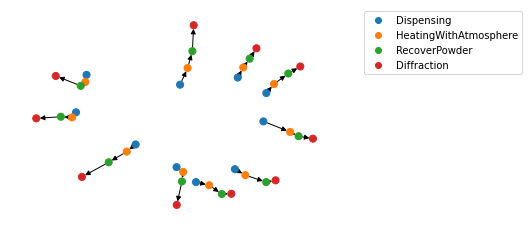

In [ ]:
plot_task_graph(g, pos_function=nx.spring_layout)

In [ ]:
count_nodes(g)

{'Dispensing': 10,
 'HeatingWithAtmosphere': 10,
 'RecoverPowder': 10,
 'Diffraction': 10}

In [ ]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  40 Number of edges:  30


In [ ]:
merge_nodes(g, "HeatingWithAtmosphere", merge_allowed_fn = lambda x,y: x["parameters"] == y["parameters"])
merge_nodes(g, "Dispensing")

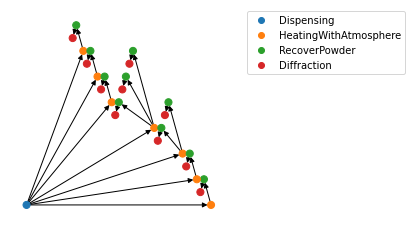

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
plot_task_graph(g, pos_function=nx.planar_layout, ax=ax)

In [ ]:
count_nodes(g)

{'Dispensing': 1,
 'HeatingWithAtmosphere': 7,
 'RecoverPowder': 10,
 'Diffraction': 10}

In [ ]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  28 Number of edges:  27


----
# Hierarchical Batching
First, bin things into furnace runs

Next, bin things into Labman workflows such that furnace runs are weighed together

In [ ]:
def get_subgraphs(graph):
    subgraphs = [graph.subgraph(c) for c in nx.connected_components(graph.to_undirected())]
    return subgraphs

In [ ]:
def subgraph_from_node(graph, node_id):
    subgraph_nodes = set([node_id])
    subgraph_nodes.update(nx.descendants(graph, node_id))
    subgraph_nodes.update(nx.ancestors(graph, node_id))
    
    return nx.subgraph(g, subgraph_nodes)

In [ ]:
exp = Experiment("dummy")
for i in range(100):
    generate_sample(exp)
exp.to_dict(); #generate prev_tasks

In [ ]:
g = nx.DiGraph()

for task_id, task in exp._tasks.items():
    g.add_node(task_id, type=task["type"], parameters=task["parameters"], capacity=task["capacity"], samples=task["samples"], parameters_per_sample = {s: task["parameters"] for s in task["samples"]})
    for prev_task_index in task["prev_tasks"]:
        prev_task_id = list(exp._tasks.keys())[prev_task_index]
        g.add_edge(prev_task_id, task_id)


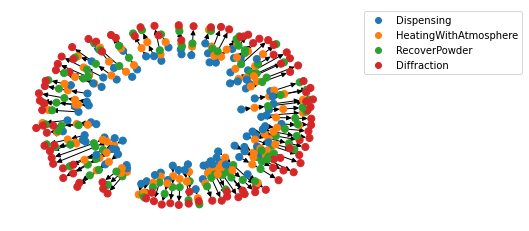

In [ ]:
plot_task_graph(g)

In [ ]:
count_nodes(g)

{'Dispensing': 100,
 'HeatingWithAtmosphere': 100,
 'RecoverPowder': 100,
 'Diffraction': 100}

In [ ]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  400 Number of edges:  300


## Batch

Batch the heating steps

In [ ]:
merge_nodes(g, "HeatingWithAtmosphere", merge_allowed_fn = lambda x,y: x["parameters"] == y["parameters"])
for subgraph in get_subgraphs(g):
    merge_nodes(subgraph, "Dispensing", parent_graph = g)
merge_nodes(g, "Dispensing")

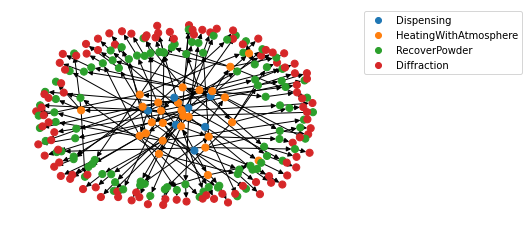

In [ ]:
plot_task_graph(g)

In [ ]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  235 Number of edges:  228


In [ ]:
count_nodes(g)

{'Dispensing': 7,
 'HeatingWithAtmosphere': 28,
 'RecoverPowder': 100,
 'Diffraction': 100}

In [ ]:
len(get_subgraphs(g))

7

In [ ]:
max_len = 0
max_len_nodeid = None
for k, v in nx.to_dict_of_dicts(g).items():
    if len(v) > max_len:
        max_len = len(v)
        max_len_nodeid = k

g.nodes[max_len_nodeid]

{'type': 'Dispensing',
 'parameters': {'powder_dispenses': {'FAI': 5.212357681042478,
   'PbBr2': 0.9669610588983502},
  'heating_duration': 300,
  'ethanol_volume': 10000,
  'transfer_volume': 8000,
  'mixer_speed': 2000,
  'mixer_duration': 900,
  'min_transfer_mass': 5},
 'capacity': 16,
 'samples': [ObjectId('6351d3c37db51dbf100bebce'),
  ObjectId('6351d3c37db51dbf100bebd5'),
  ObjectId('6351d3c37db51dbf100bebc1'),
  ObjectId('6351d3c37db51dbf100bebb8'),
  ObjectId('6351d3c37db51dbf100bebcf'),
  ObjectId('6351d3c37db51dbf100bebd1'),
  ObjectId('6351d3c37db51dbf100bebcd'),
  ObjectId('6351d3c37db51dbf100bebd0'),
  ObjectId('6351d3c37db51dbf100bebd3'),
  ObjectId('6351d3c37db51dbf100bebd7'),
  ObjectId('6351d3c37db51dbf100bebc9'),
  ObjectId('6351d3c37db51dbf100bebe3'),
  ObjectId('6351d3c37db51dbf100bebd4'),
  ObjectId('6351d3c37db51dbf100bebda'),
  ObjectId('6351d3c37db51dbf100bebdf'),
  ObjectId('6351d3c37db51dbf100bebe8')],
 'parameters_per_sample': {ObjectId('6351d3c37db51dbf100

Batch the Dispensing steps

In [ ]:
subgraphs = get_subgraphs(g)

In [ ]:
def powder_set_similarity(a:list, b:list):
    a_set = set()
    for p in a:
        a_set.update(p["parameters"]["powder_dispenses"])
    
    b_set = set()
    for p in b:
        b_set.update(p["parameters"]["powder_dispenses"])
        
    return 1-len(a_set.intersection(b_set)) / len(a_set.union(b_set))

In [ ]:
from functools import lru_cache

@lru_cache(maxsize=1000)
def get_dispenses_from_node(graph, node_id):
    sg = subgraph_from_node(graph, node_id)
    dispenses = [node for node_id, node in sg.nodes(data=True) if node["type"] == "Dispensing"]
    return dispenses

In [ ]:
heating_node_ids = [node_id for node_id, node in g.nodes(data=True) if node["type"] in ["Heating", "HeatingWithAtmosphere"]]
dispense_node_ids = [node_id for node_id, node in g.nodes(data=True) if node["type"] == "Dispensing"]

similarity = np.ones((len(heating_node_ids), len(heating_node_ids)))
for i in range(len(heating_node_ids)):
    for j in range(len(heating_node_ids)):
        if i == j:
            continue
        if i < j:
            continue
        dispenses_i = get_dispenses_from_node(g, heating_node_ids[i])
        dispenses_j = get_dispenses_from_node(g, heating_node_ids[j])
        similarity[i,j] = similarity[j,i] = powder_set_similarity(dispenses_i, dispenses_j)

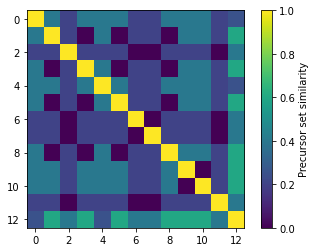

In [ ]:
plt.imshow(similarity, vmin=0, vmax=1)
plt.colorbar(label="Precursor set similarity")

In [ ]:
powders = {}
for node_id in dispense_node_ids:
    powders[node_id] = set([p for p in g.nodes[node_id]["parameters"]["powder_dispenses"]])
unique_powders = list(set.union(*powders.values()))

powder_in_dispense = []
for powd in powders.values():
    powder_in_dispense.append([p in powd for p in unique_powders])


In [ ]:
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver.CreateSolver('SCIP')



In [ ]:
for reference_node_id in heating_node_ids:
    preferred_pairings = heating_node_ids.copy()
    reference_dispenses = get_dispenses_from_node(g, reference_node_id)
    preferred_pairings.sort(key = lambda x: powder_set_similarity(reference_dispenses, get_dispenses_from_node(g, x)), reverse=True) #most to least similar
    
    for pair_id in preferred_pairings:
        if pair_id == reference_node_id:
            continue
        
    reference_node_id = node_ids[reference_index]
    ref = g.nodes[reference_node_id]
    if ref["type"] != "Dispensing":
        continue
    replace = []
    capacity = ref["capacity"]
    ref_samples = ref["samples"]

    for tid, task in g.nodes(data=True):
        if task["type"] != "Dispensing":
                continue
        if tid == reference_node_id:
            continue

        if len(task["samples"]) + len(ref_samples) > capacity:
            continue
        replace.append(tid)
        ref_samples.extend(task["samples"])

        if len(ref_samples) == capacity:
            break
    
    if len(replace) == 0:
        continue
    for replace_id in replace:
        for prev in g.predecessors(replace_id):
            g.add_edge(prev, reference_node_id)
        for next in g.successors(replace_id):
            g.add_edge(reference_node_id, next)
        g.remove_node(replace_id)
        node_ids.remove(replace_id)
    g.nodes[reference_node_id]["samples"] = ref_samples

    

IndexError: list index out of range

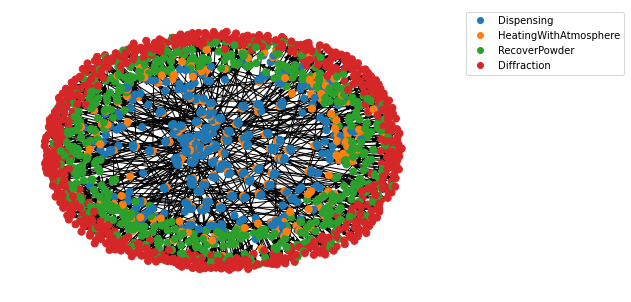

In [ ]:
plot_task_graph(g)

In [ ]:
count_nodes(g)

{'Dispensing': 550,
 'HeatingWithAtmosphere': 230,
 'RecoverPowder': 550,
 'Diffraction': 550}

In [ ]:
print("Number of nodes: ", len(g.nodes), "Number of edges: ", len(g.edges))

Number of nodes:  1880 Number of edges:  1650


----

# Using final functions

In [1]:
from alab_experiment_helper.sample import Sample
# from alab_experiment_helper.batch import Batch
from alab_experiment_helper import tasks
from alab_experiment_helper.views import SampleView

from alab_experiment_helper.batching.utils import (
    experiment_to_digraph,
    get_subgraphs,
    subgraph_from_node,
    merge_nodes,
    plot_task_graph
)
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

In [2]:
sv = SampleView()
sv._clear_collection()

In [3]:
samples = []
for i in range(10):
    samples.append(Sample("sample_{}".format(i)))

In [4]:
for s in samples:
    tasks.starting(s, "loading_rack")
tasks.alab_heating(samples, heating_time_minutes=60, heating_temperature_celsius=1000)
for s in samples:
    tasks.recover_powder(s)
    tasks.xrd(s)

In [5]:
for s in samples:
    sv.add_sample(s)

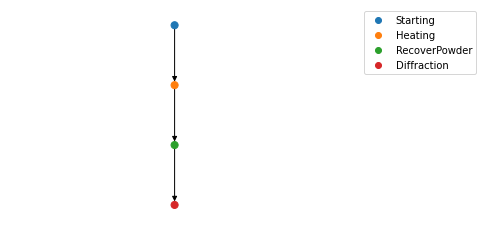

In [6]:
graphs = [experiment_to_digraph(s) for s in samples]
# g2 = experiment_to_digraph(b2)

plot_task_graph(graphs[0])

In [7]:
from alab_experiment_helper.batching.worker import QueueWorker

In [8]:
qw = QueueWorker(api_url = "http://127.0.0.1", api_port = 8896)

In [13]:
qw.process_pending_samples()